In [1]:
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [2]:
#importing libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [8]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','Sri','sri','Lanka','Lankan','lanka','SL','sl'])

In [52]:
# Import Dataset
df = pd.read_excel('/Users/Suwani/Desktop/Moodys Project/Cleaned data/2019/sep19_cleaned.xlsx')
df = df.drop_duplicates(keep='first')

In [53]:
# Getting rid of new lines, space, emails using regular expression
# Convert to list
data = df.Headline.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove single quotes
data = [re.sub("\'", "", sent) for sent in data]


In [54]:
#Tokenize words and Clean-up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['sri', 'lanka', 'is', 'running', 'out', 'of', 'time', 'to', 'agree', 'on', 'mcc', 'compact', 'mcc', 'country', 'director']]


In [55]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [56]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [57]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['run', 'time', 'agree', 'mcc', 'compact', 'mcc', 'country', 'director']]


In [58]:
#Create the Dictionary and Corpus (collection of documents) needed for Topic Modeling
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
#(0,1) implies that word id 1 occurs once in the first document
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1)]]


In [59]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=50,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
#chunksize:is the number of documents to be used in each training chunk
#update_every determines how often the model parameters should be updated
#passes is the total number of training passes


In [60]:
# Print the Keyword in the 10 topics
#keywords for each topic and the weightage(importance) of each keyword can be seen in the output
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.037*"lankan" + 0.015*"first" + 0.011*"colombo" + 0.011*"tower" + '
  '0.011*"go" + 0.009*"president" + 0.008*"australia" + 0.007*"government" + '
  '0.007*"rate" + 0.007*"youth"'),
 (1,
  '0.029*"presidential" + 0.017*"month" + 0.013*"leader" + 0.010*"launch" + '
  '0.010*"emerge" + 0.009*"low" + 0.009*"rajapaksa" + 0.009*"nominee" + '
  '0.009*"fall" + 0.009*"world"'),
 (2,
  '0.020*"bank" + 0.014*"year" + 0.013*"hold" + 0.012*"cut" + 0.011*"say" + '
  '0.010*"asia" + 0.009*"corruption" + 0.008*"day" + 0.008*"chief" + '
  '0.008*"test"'),
 (3,
  '0.016*"central" + 0.013*"candidate" + 0.011*"slfp" + 0.011*"rise" + '
  '0.010*"minister" + 0.010*"party" + 0.010*"seek" + 0.009*"suspect" + '
  '0.008*"close" + 0.007*"lankas"'),
 (4,
  '0.021*"win" + 0.018*"new" + 0.017*"award" + 0.017*"india" + 0.015*"china" + '
  '0.013*"series" + 0.012*"open" + 0.012*"second" + 0.008*"woman" + '
  '0.007*"school"')]


In [61]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.744596242693504

Coherence Score:  0.6869323156924295


In [62]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.234720 -0.024898       1        1  25.112066
1     -0.073011 -0.177420       2        1  19.556179
2     -0.108026 -0.013415       3        1  19.033102
0     -0.044339  0.186965       4        1  18.805180
3     -0.009345  0.028769       5        1  17.493469, topic_info=     Category       Freq          Term      Total  loglift  logprob
42    Default  44.000000        lankan  44.000000  30.0000  30.0000
833   Default  35.000000  presidential  35.000000  29.0000  29.0000
237   Default  32.000000           win  32.000000  28.0000  28.0000
549   Default  24.000000          bank  24.000000  27.0000  27.0000
246   Default  28.000000           new  28.000000  26.0000  26.0000
398   Default  27.000000         award  27.000000  25.0000  25.0000
441   Default  27.000000         india  27.000000  24.0000  24.0000
109   Default  20.000000         month  20.000000  23.0000  23.0000
373   Default  23.000000         china  23.000000  22.0000  22.0000
792   Default  17.000000       central  17.000000  21.0000  21.0000
70    Default  18.000000         first  18.000000  20.0000  20.0000
183   Default  16.000000          year  16.000000  19.0000  19.0000
32    Default  20.000000        series  20.000000  18.0000  18.0000
87    Default  16.000000          hold  16.000000  17.0000  17.0000
697   Default  15.000000        leader  15.000000  16.0000  16.0000
883   Default  14.000000     candidate  14.000000  15.0000  15.0000
861   Default  15.000000           cut  15.000000  14.0000  14.0000
383   Default  18.000000          open  18.000000  13.0000  13.0000
234   Default  18.000000        second  18.000000  12.0000  12.0000
531   Default  13.000000       colombo  13.000000  11.0000  11.0000
747   Default  13.000000          slfp  13.000000  10.0000  10.0000
1055  Default  13.000000         tower  13.000000   9.0000   9.0000
443   Default  13.000000           say  13.000000   8.0000   8.0000
752   Default  12.000000          rise  12.000000   7.0000   7.0000
228   Default  12.000000            go  12.000000   6.0000   6.0000
53    Default  11.000000      minister  11.000000   5.0000   5.0000
46    Default  12.000000        launch  12.000000   4.0000   4.0000
156   Default  11.000000         party  11.000000   3.0000   3.0000
1477  Default  12.000000        emerge  12.000000   2.0000   2.0000
426   Default  11.000000          seek  11.000000   1.0000   1.0000
...       ...        ...           ...        ...      ...      ...
53     Topic5  11.190225      minister  11.736130   1.6957  -4.5755
156    Topic5  10.817370         party  11.359753   1.6944  -4.6094
426    Topic5  10.695878          seek  11.251077   1.6927  -4.6207
830    Topic5  10.072938       suspect  10.622962   1.6902  -4.6807
752    Topic5  12.063683          rise  12.803637   1.6838  -4.5004
107    Topic5   8.977987         close   9.610587   1.6753  -4.7958
864    Topic5   7.508495          case   8.069352   1.6713  -4.9745
192    Topic5   7.267798           top   7.811109   1.6712  -5.0071
557    Topic5   7.238955         sport   7.791086   1.6698  -5.0111
848    Topic5   6.656791        arrest   7.198489   1.6651  -5.0949
1115   Topic5   6.484318           way   7.038755   1.6613  -5.1212
451    Topic5   6.378962          name   6.943603   1.6585  -5.1376
34     Topic5   6.059060          navy   6.606741   1.6568  -5.1890
380    Topic5   6.002322          lose   6.545527   1.6567  -5.1984
508    Topic5   5.867355        vision   6.421492   1.6531  -5.2212
1108   Topic5   5.149805      chairman   5.696361   1.6425  -5.3516
2441   Topic5   5.391165       recover   5.975572   1.6404  -5.3058
588    Topic5   5.049015          sept   5.599312   1.6399  -5.3714
688    Topic5   4.969385        honour   5.525842   1.6372  -5.3873
2      Topic5   4.771739       country   5.316660   1.6352  -5.4279
14     Topic5   4.737097          meet   5.

### Optimal number of topics for LDA

In [63]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [64]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

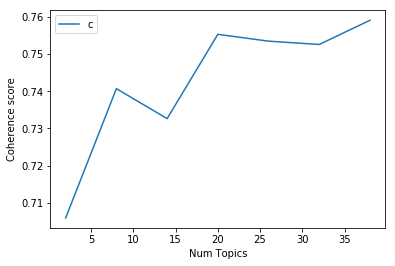

In [65]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [66]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.706
Num Topics = 8  has Coherence Value of 0.7407
Num Topics = 14  has Coherence Value of 0.7326
Num Topics = 20  has Coherence Value of 0.7553
Num Topics = 26  has Coherence Value of 0.7535
Num Topics = 32  has Coherence Value of 0.7526
Num Topics = 38  has Coherence Value of 0.7591


In [67]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.066*"award" + 0.053*"win" + 0.017*"good" + 0.016*"tourism" + '
  '0.016*"security" + 0.015*"export" + 0.013*"championship" + 0.012*"industry" '
  '+ 0.011*"bag" + 0.011*"gold"'),
 (1,
  '0.025*"india" + 0.020*"woman" + 0.017*"remand" + 0.016*"conference" + '
  '0.016*"champion" + 0.014*"central" + 0.014*"power" + 0.013*"arrest" + '
  '0.013*"time" + 0.011*"hold"'),
 (2,
  '0.032*"today" + 0.022*"cricket" + 0.022*"school" + 0.017*"indian" + '
  '0.016*"strike" + 0.015*"pm" + 0.013*"election" + 0.012*"top" + 0.012*"navy" '
  '+ 0.011*"challenge"'),
 (3,
  '0.030*"year" + 0.028*"president" + 0.028*"presidential" + 0.019*"slfp" + '
  '0.018*"celebrate" + 0.013*"sector" + 0.013*"sign" + 0.011*"technology" + '
  '0.011*"port" + 0.011*"sept"'),
 (4,
  '0.039*"launch" + 0.035*"world" + 0.026*"colombo" + 0.025*"life" + '
  '0.024*"leader" + 0.021*"series" + 0.018*"hold" + 0.014*"country" + '
  '0.013*"close" + 0.011*"economic"'),
 (5,
  '0.025*"asia" + 0.023*"national" + 0.020*"call" 

#### Finding the dominant topic in each sentence

In [68]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.1614,"today, cricket, school, indian, strike, pm, el...",“Sri Lanka is running out of time to agree on ...
1,1,1.0,0.1368,"india, woman, remand, conference, champion, ce...",A 4th coal power plant for Sri Lanka?
2,2,5.0,0.1614,"asia, national, call, host, insurance, austral...",Sri Lanka’s UN delegation meets with Under Sec...
3,3,5.0,0.1466,"asia, national, call, host, insurance, austral...",Sri Lanka welcomes proposal for Maldives’ re-a...
4,4,3.0,0.1473,"year, president, presidential, slfp, celebrate...",Sri Lanka celebrates World Tourism Day 2019 wi...
5,5,3.0,0.1548,"year, president, presidential, slfp, celebrate...",Sri Lanka arrives in Karachi for SL vs Pak series
6,6,2.0,0.2005,"today, cricket, school, indian, strike, pm, el...",Yoshitha Rajapaksa reinstated as Lieutenant of...
7,7,4.0,0.1334,"launch, world, colombo, life, leader, series, ...",PM admits his involvement in the collapse of S...
8,8,4.0,0.1439,"launch, world, colombo, life, leader, series, ...",Sri Lanka Administrative Service Association t...
9,9,4.0,0.1633,"launch, world, colombo, life, leader, series, ...",Sisu Dham Sewana will help Buddhism flourish i...


####  Find the most representative document for each topic

In [69]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2009,"award, win, good, tourism, security, export, c...",Ajith Fernando wins AIA Legend Award
1,1.0,0.1896,"india, woman, remand, conference, champion, ce...",Causeway Paints encourages painters with Paint...
2,2.0,0.2055,"today, cricket, school, indian, strike, pm, el...",Top school cricketers to be crowned today at g...
3,3.0,0.1884,"year, president, presidential, slfp, celebrate...",SLFP tells EC: will field presidential candidate
4,4.0,0.2188,"launch, world, colombo, life, leader, series, ...",Nethmal plays key role in St. Joseph Vaz’ success
5,5.0,0.1823,"asia, national, call, host, insurance, austral...",‘See through fake information to find Sri Lank...
6,6.0,0.1831,"lankan, open, state, day, minister, high, serv...",SLT Speed Up Cycle Sawariya begins from Galle ...
7,7.0,0.1901,"partner, bank, asian, suspect, global, free, s...",Singer partners AB Mauri to enhance standard o...


#### Topic distribution across documents

In [70]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,2.0,"today, cricket, school, indian, strike, pm, el...",189.0,0.1665
1,1.0,"india, woman, remand, conference, champion, ce...",144.0,0.1269
2,5.0,"asia, national, call, host, insurance, austral...",166.0,0.1463
3,5.0,"asia, national, call, host, insurance, austral...",144.0,0.1269
4,3.0,"year, president, presidential, slfp, celebrate...",141.0,0.1242
5,3.0,"year, president, presidential, slfp, celebrate...",127.0,0.1119
6,2.0,"today, cricket, school, indian, strike, pm, el...",109.0,0.0960
7,4.0,"launch, world, colombo, life, leader, series, ...",115.0,0.1013
8,4.0,"launch, world, colombo, life, leader, series, ...",NaN,NaN
9,4.0,"launch, world, colombo, life, leader, series, ...",NaN,NaN
